```
Running opendrift in the Boknafjord

Copyright (C) 2023 SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
from opendrift.models.oceandrift import OceanDrift
from datetime import datetime, timedelta

import xarray as xr
from matplotlib import pyplot as plt
import numpy as np

import sys, os

In [2]:
source_url = "/sintef/data/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"
os.path.isfile(source_url)

True

In [3]:
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 801,
                  xi_rho: 1161, eta_u: 801, xi_u: 1160, eta_v: 800, xi_v: 1161)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2019-11-01T01:00:00 ... 2019-11-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

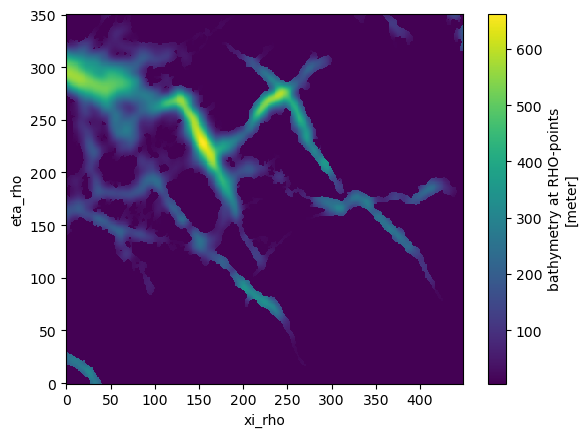

In [4]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 687, dimX-25, 120, dimY-330
ds.h.isel(eta_rho=slice(y0, y1), xi_rho=slice(x0,x1)).plot()

## OpenDrift

In [5]:
reader_boknafjorden = reader_ROMS_native.Reader(source_url)
reader_boknafjorden.start_time

No proj string or projection could be derived, using 'fakeproj'. This assumes that the variables are structured and gridded approximately equidistantly on the surface (i.e. in meters). This must be guaranteed by the user. You can get rid of this warning by supplying a valid projection to the reader.


datetime.datetime(2019, 11, 1, 1, 0)

In [6]:
# Checking how to map (x,y) to/from (lon, lat)

#eta_rho: 801 xi_rho: 1161
lon0 = ds.lon_rho.isel(eta_rho=0, xi_rho=0).data, 
lat0 = ds.lat_rho.isel(eta_rho=0, xi_rho=0).data
print("lonlat(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lon0, lat0))

lonend = ds.lon_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
latend = ds.lat_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
print("lonlat(-1, -1): ", (lonend, latend))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lonend, latend))


lon0u = ds.lon_u.isel(eta_u=0, xi_u=0).data, 
lat0u = ds.lat_u.isel(eta_u=0, xi_u=0).data
print("lonlatu(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader_boknafjorden.lonlat2xy(lon0, lat0))

lonlat(0, 0):  ((array(5.73786262),), array(58.00917678))
	gives (x, y):  (array([0.]), array([0.]))
lonlat(-1, -1):  (array(5.11597068), array(59.99781934))
	gives (x, y):  (array(1160.), array(800.))
lonlatu(0, 0):  ((array(5.73786262),), array(58.00917678))
	gives (x, y):  (array([0.]), array([0.]))


Based on the dimensions of eta_* and xi_*, it seems that eta_rho and xi_rho is from boundary to boundary. 

In [7]:
# Translate initx, inity to initlon, initlat
initx = np.array([12500,  7500, 12500,  1250,  7500])
inity = np.array([40000, 42500, 45000, 43750, 45000])

init_local_index_x = initx/160
init_local_index_y = inity/160

init_global_index_x = init_local_index_x + x0
init_global_index_y = init_local_index_y + y0

print(init_local_index_x)
print(init_global_index_x)

init_lon, init_lat = reader_boknafjorden.xy2lonlat(init_global_index_x, init_global_index_y)
print("init_lon: ", init_lon)
print("init_lat: ", init_lat)

[78.125  46.875  78.125   7.8125 46.875 ]
[765.125  733.875  765.125  694.8125 733.875 ]
init_lon:  [5.73497767 5.65788755 5.65634236 5.59118576 5.61859841]
init_lat:  [59.22190485 59.19130585 59.24129537 59.14575134 59.20097932]


In [8]:
o = OceanDrift(loglevel=20)

#o.add_reader([reader_barents, reader_wind])
o.add_reader(reader_boknafjorden)


10:50:43 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.5)


In [9]:
o.seed_elements(lat=init_lat, lon=init_lon, time=reader_boknafjorden.start_time, 
                wind_drift_factor=np.zeros_like(init_lat))


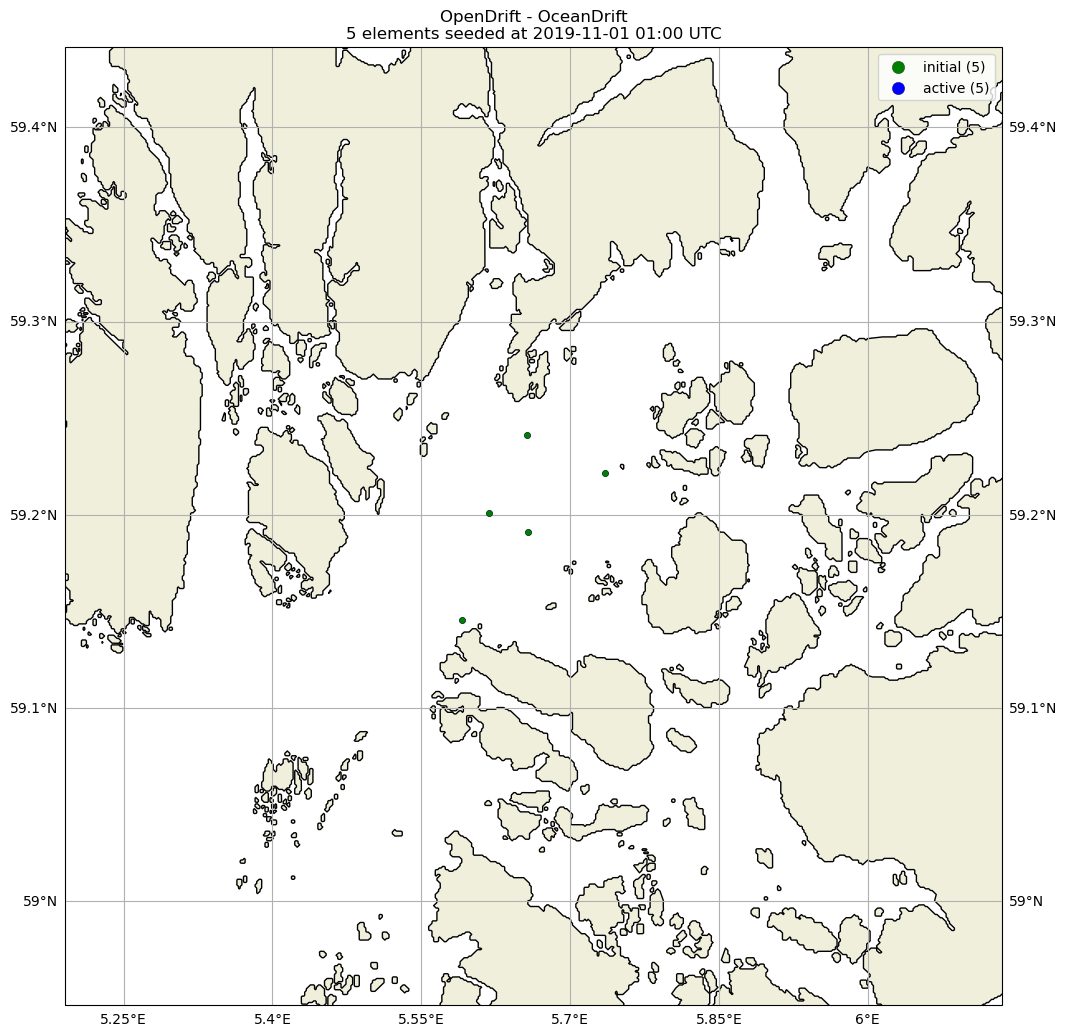

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n5 elements seeded at 2019-11-01 01:00 UTC'}>,
 <Figure size 1072.94x1100 with 1 Axes>)

In [10]:
o.plot()

In [11]:
o.run(duration = timedelta(hours=6), time_step=600, time_step_output=600)


10:51:21 INFO    opendrift.models.basemodel:2574: Fallback values will be used for the following variables which have no readers: 
10:51:21 INFO    opendrift.models.basemodel:2577: 	upward_sea_water_velocity: 0.000000
10:51:21 INFO    opendrift.models.basemodel:2577: 	sea_surface_wave_significant_height: 0.000000
10:51:21 INFO    opendrift.models.basemodel:2577: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
10:51:21 INFO    opendrift.models.basemodel:2577: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
10:51:21 INFO    opendrift.models.basemodel:2577: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
10:51:21 INFO    opendrift.models.basemodel:2577: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
10:51:21 INFO    opendrift.models.basemodel:2577: 	surface_downward_x_stress: 0.000000
10:51:21 INFO    opendrift.models.basemodel:2577: 	surface_downward_y_stress: 0.000000
10:51:21 INFO    opendrift.models.basemo

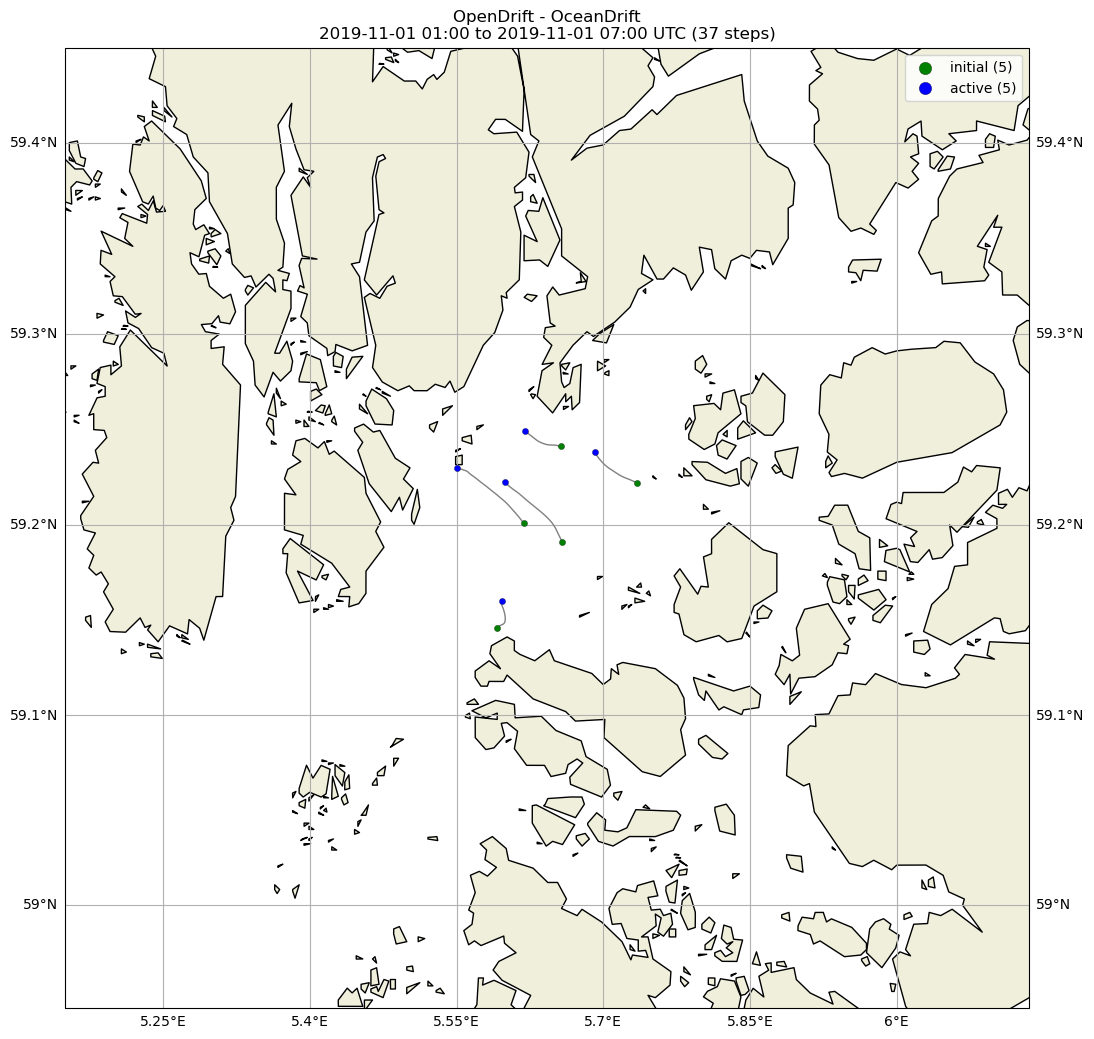

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2019-11-01 01:00 to 2019-11-01 07:00 UTC (37 steps)'}>,
 <Figure size 1100x1098.49 with 1 Axes>)

In [12]:
o.plot()

10:51:37 WARNING opendrift.models.basemodel:3209: Plotting fast. This will make your plots less accurate.


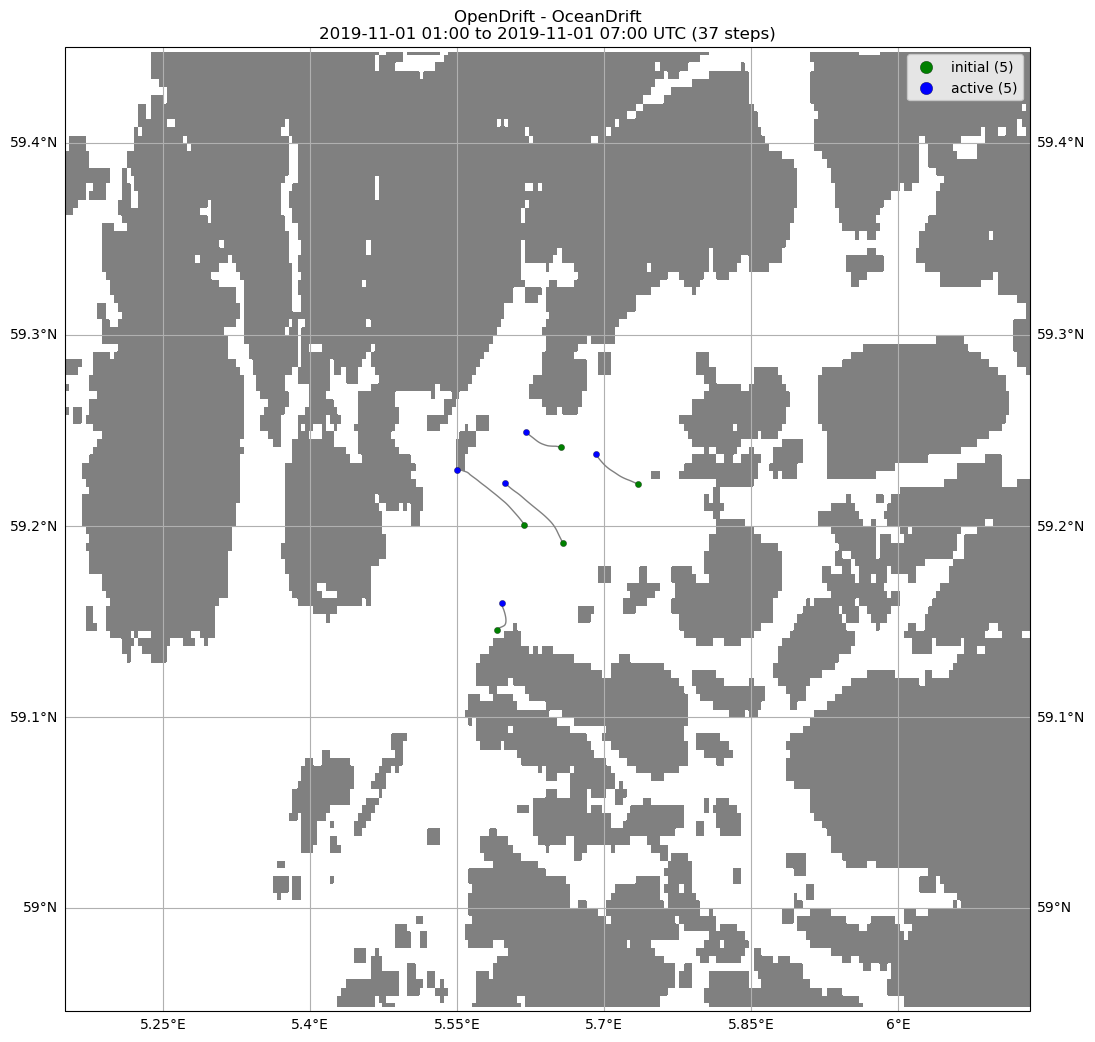

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2019-11-01 01:00 to 2019-11-01 07:00 UTC (37 steps)'}>,
 <Figure size 1100x1098.49 with 1 Axes>)

In [13]:
o.plot(fast=True)